# Suite minimisante non-linéaire (duale)
L'objectif est de tracer l'évolution des énergies magnétiques dans l'axe $d$ et l'axe $q$  à flux fixé en fonction du nombre de barres, et de la comparer à celles d'un matériau anisotrope homogénéisé en non-linéaire.

In [1]:
# Enlever les  # pour que les figures s'ouvrent dans une fenêtre interactive à part

#%matplotlib qt5
from module_optim_topo import *
from ngsolve.solvers import Newton
from IPython.display import clear_output
from scipy.optimize import root
from copy import copy
#plt.ion()

In [2]:
# Induction moyenne : 

Bmoyen = 1.25

## 1) Définition du matériau non-linéaire

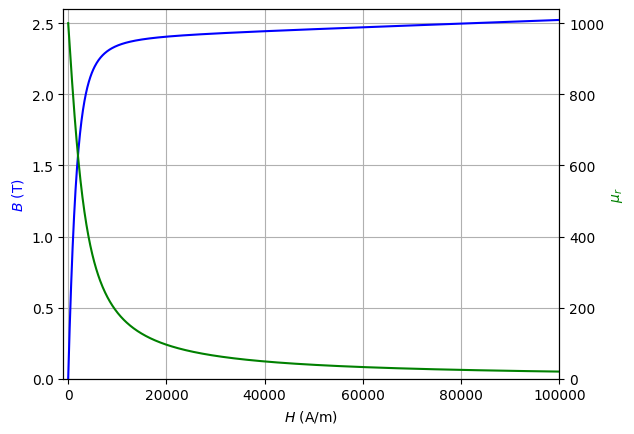

In [3]:
mu_r0 = 1000
hsat = 3e6/mu_r0
mu0 = 4e-7*np.pi

def b(h):
    if str(type(h)) == "<class 'numpy.ndarray'>":
        return mu0*(2*mu_r0*h-(np.arctan(h/hsat)/np.pi+0.5)*(2*mu_r0-1)*h )
    return mu0*(2*mu_r0*h-(atan(h/hsat)/np.pi+0.5)*(2*mu_r0-1)*h )

def dbdh(h):
    if str(type(h)) == "<class 'numpy.ndarray'>":
        return -mu0*(((2*mu_r0 - 1)*(pi + 2*np.arctan(h/hsat)))/(2*np.pi) - 2*mu_r0 + (h*hsat*(mu_r0 - 1))/(np.pi*(h**2 + hsat**2)))
    return -mu0*(((2*mu_r0 - 1)*(pi + 2*atan(h/hsat)))/(2*np.pi) - 2*mu_r0 + (h*hsat*(mu_r0 - 1))/(np.pi*(h**2 + hsat**2)))

def mu(phi,rho):
    h = sqrt(grad(phi)*grad(phi)+1e-20)
    return mu0 + (b(h)/h-mu0)*rho

# Tracé
H = np.linspace(1e-6,1e5,1000)
fig, ax1 = plt.subplots()
plt.grid()
ax2 = ax1.twinx()
ax1.plot(H,b(H), 'b-') ; ax2.plot(H,b(H)/H/mu0, 'g-')

ax1.axis([-1000,1e5,0,2.6]) ;
ax1.set_xlabel('$H$ (A/m)') ; ax1.set_ylabel('$B$ (T)', color='b')
ax2.set_ylabel('$\mu_r$', color='g') ; ax2.axis([-1000,1e5,0,1040])
plt.show()

## 2) Eléments finis non-linéaires

In [4]:
def solveDual_NL(rho, bmoy ,mesh):
    # le champ 1 est vertical, le champ 2 est horizontal
    # on impose les flux
        
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    
    K1 = BilinearForm(fespace_H1, symmetric=True)
    K1 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx
    K1 += psi*bmoy*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("right_bot|left_bot"))
    K1 += -psi*bmoy*sqrt(1-x**2)*ds(definedon=mesh.Boundaries("left_up|right_up"))
    
    K2 = BilinearForm(fespace_H1, symmetric=True)
    K2 +=  grad(psi)*mu(phi,rho)*grad(phi)*dx
    K2 += -psi*bmoy*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("right_up|right_bot"))
    K2 += psi*bmoy*sqrt(1-y**2)*ds(definedon=mesh.Boundaries("left_up|left_bot"))
    
    phi1 = GridFunction(fespace_H1)
    phi2 = GridFunction(fespace_H1)
    Newton(K1,phi1, freedofs = fespace_H1.FreeDofs() ,printing=False, maxit=100, maxerr=5e-10,dampfactor = 0.1, inverse="pardiso")
    Newton(K2,phi2, freedofs = fespace_H1.FreeDofs() ,printing=False, maxit=100, maxerr=5e-10,dampfactor = 0.1, inverse="pardiso")
    
    return phi1, phi2

   ## 3) Suite minimisante non-linéaire

In [5]:
# Boucle de calcul

maxN = 100
Jd_dual = []; Jq_dual = []; J_dual = []

for i in range(3,maxN,4):
    
    # Génération du maillage comportant i barres de fer et d'air
    mesh = meshLamDisk(i, h = 1/maxN)
    
    # Résolution du problème éléments finis
    ud, uq = solveDual_NL(rho_defaut(mesh), Bmoyen ,mesh)
    
    # Calcul des énergies magnétiques
    Jd_dual.append(compliance(ud, mu(ud, rho_defaut(mesh)), mesh))
    Jq_dual.append(compliance(uq, mu(uq, rho_defaut(mesh)), mesh))
    J_dual.append(Jq_dual[-1]-Jd_dual[-1])
    
    print(f'{i} barres - Jd = {np.round(Jd_dual[-1],2)} - Jq = {np.round(Jq_dual[-1])}')

3 barres - Jd = 254283.86 - Jq = 977911.0
7 barres - Jd = 179591.14 - Jq = 977910.0
11 barres - Jd = 151077.11 - Jq = 977911.0
15 barres - Jd = 135578.13 - Jq = 977911.0
19 barres - Jd = 125765.95 - Jq = 977910.0
23 barres - Jd = 118983.09 - Jq = 977911.0
27 barres - Jd = 113948.28 - Jq = 977910.0
31 barres - Jd = 110085.77 - Jq = 977910.0
35 barres - Jd = 107037.55 - Jq = 977910.0
39 barres - Jd = 104516.85 - Jq = 977911.0
43 barres - Jd = 102489.68 - Jq = 977910.0
47 barres - Jd = 100682.87 - Jq = 977912.0
51 barres - Jd = 99224.4 - Jq = 977911.0
55 barres - Jd = 97907.34 - Jq = 977909.0
59 barres - Jd = 96701.76 - Jq = 977912.0
63 barres - Jd = 95672.5 - Jq = 977912.0
67 barres - Jd = 94773.46 - Jq = 977911.0
71 barres - Jd = 93955.28 - Jq = 977910.0
75 barres - Jd = 93234.01 - Jq = 977909.0
79 barres - Jd = 92570.76 - Jq = 977908.0
83 barres - Jd = 91795.19 - Jq = 977913.0
87 barres - Jd = 91157.64 - Jq = 977914.0
91 barres - Jd = 90623.52 - Jq = 977914.0
95 barres - Jd = 90147.01 

## 4) Tracés

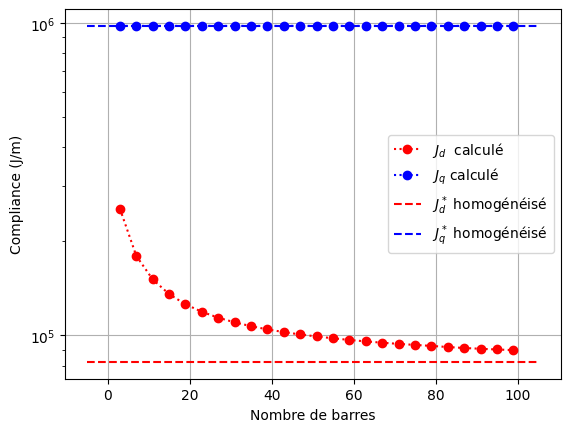

In [6]:
frac_vol = 0.5 # fraction volumique (fixée à 0.5)

# Définition des fonctions réciproques (en fonction de B et pas H)
Hlist = np.append(np.logspace(1,7,10000000),1e300)
Blist = b(Hlist)
muferlist = Blist/Hlist
muferlist = np.insert(muferlist,0,muferlist[0])
Blist = np.insert(Blist,0,0)

def H(B):
    return np.interp(B, Blist, Hlist)

def mufer(B):
    return np.interp(B, Blist, muferlist)

# Réluctivités du matériau homogénéisé dans les axes d et q
# calculées pour une fraction volumique de 0.5 et une induction de 1.25T

muq_NL = 1/(frac_vol/mufer(Bmoyen) + (1-frac_vol)/mu0)

# calcul du Blocal dans le fer

Bfer, Bair = root(lambda B: [ B[0]/mufer(B[0]) - B[1]/mu0, 1e7*frac_vol*B[0] + 1e7*(1-frac_vol)*B[1]  - 1e7*Bmoyen],
                  [0.1,0.1], tol=1e-10, method = 'lm',
                  options = {'gtol': 1e-10, 'xtol':1e-10, 'ftol': 1e-10})['x']

mud_NL = frac_vol*mufer(Bfer) + (1-frac_vol)*mu0

# Valeurs théoriques de l'énergie magnétique pour un matériau anisotrope
Jd_lamine = np.pi/2 /  mud_NL * Bmoyen**2 
Jq_lamine_dual = np.pi/2 / muq_NL * Bmoyen**2 

# Tracé de l'évolution de l'énergie
plt.semilogy(list(range(3,maxN,4)),Jd_dual,'r:o',label = '$J_d$  calculé')
plt.semilogy(list(range(3,maxN,4)),Jq_dual,'b:o',label = '$J_q$ calculé')
plt.semilogy([-5,maxN+5],[Jd_lamine,Jd_lamine],'r--',label = '$J_d^*$ homogénéisé')
plt.semilogy([-5,maxN+5],[Jq_lamine_dual,Jq_lamine_dual],'b--',label = '$J_q^*$ homogénéisé')
plt.legend(); plt.grid()
plt.xlabel('Nombre de barres')
plt.ylabel('Compliance (J/m)')
plt.show()